Using INR/USD exchange rate for analysis.


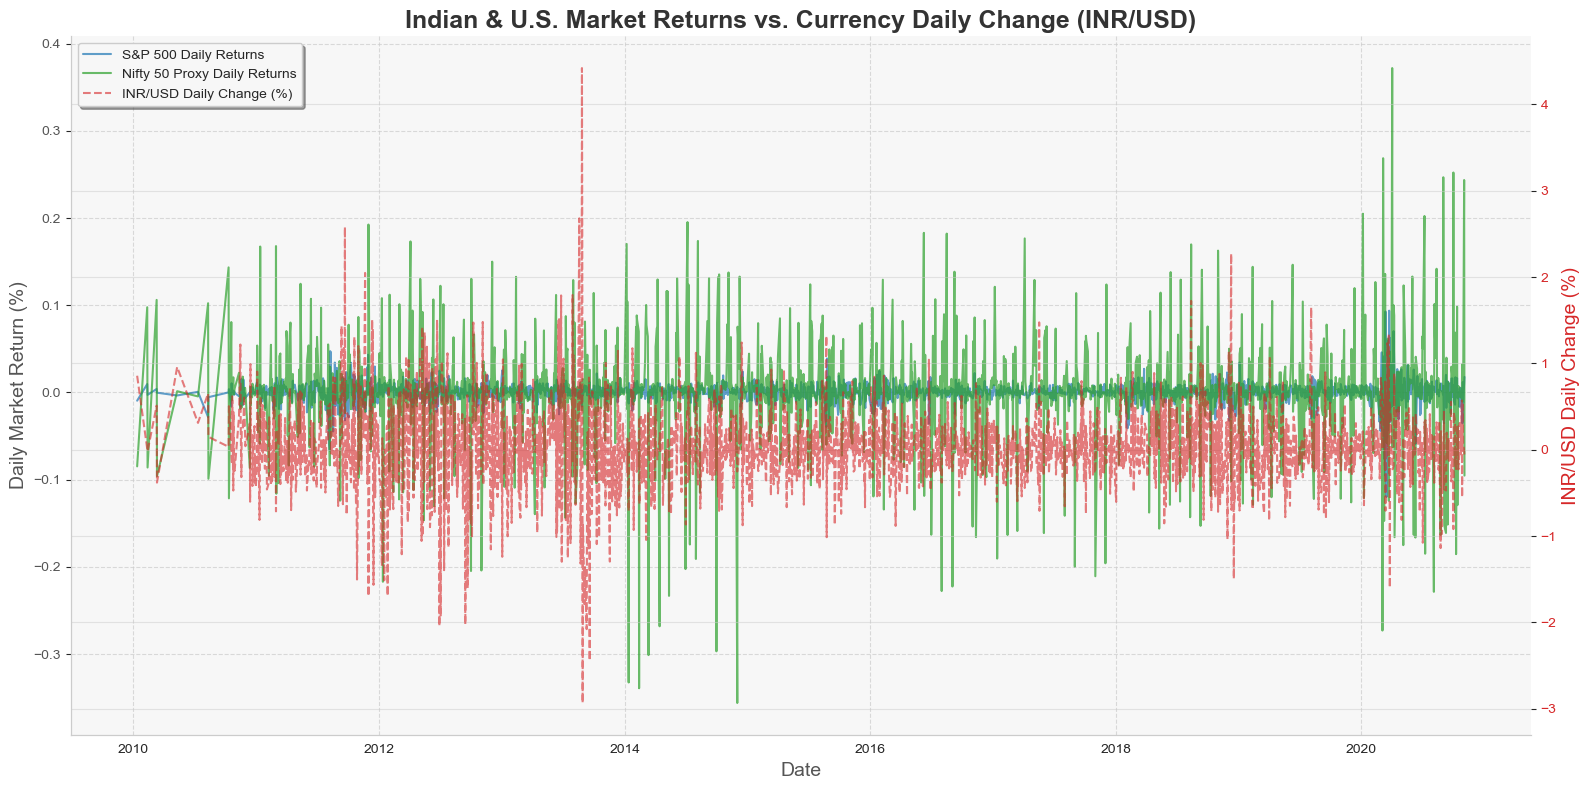

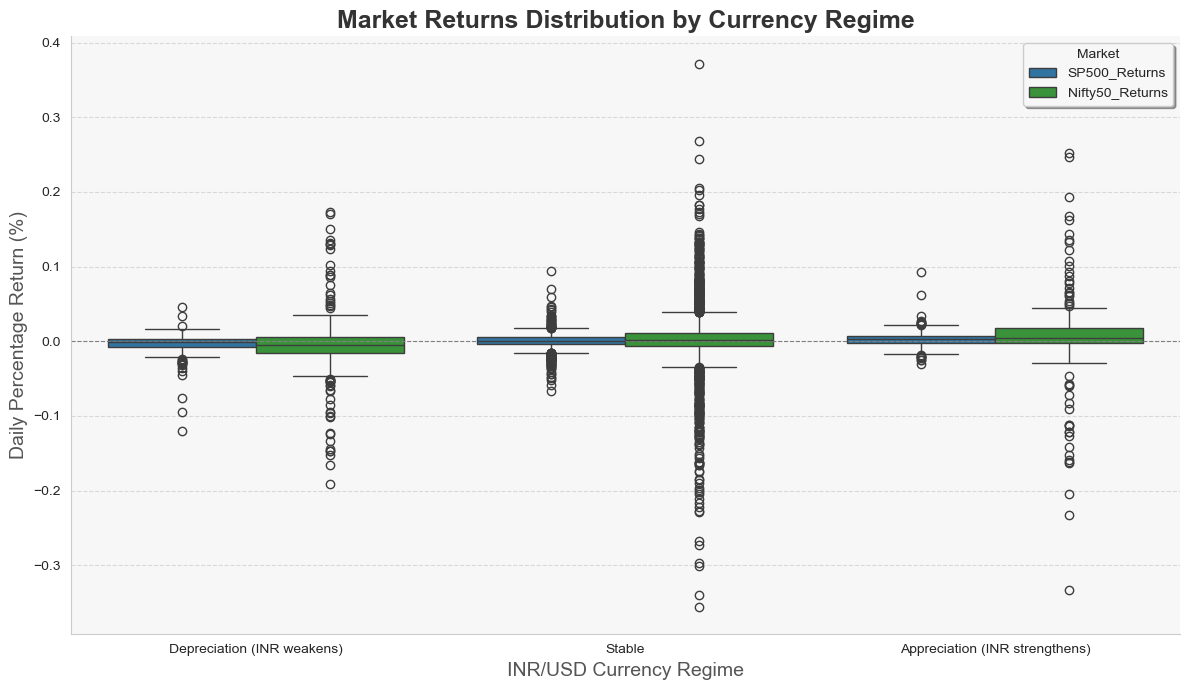

Currency-Market Behavior charts generated and saved.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# --- 1. Load the Datasets ---
try:
    sp500_df = pd.read_csv('SPX.csv', parse_dates=['Date'])
    nifty50_stocks_df = pd.read_csv('Final-50-stocks.csv', parse_dates=['DATE'])
    exchange_rates_df = pd.read_csv('exchange_rates.csv', parse_dates=['date'])
except FileNotFoundError:
    print("Error: Make sure 'SPX.csv', 'Final-50-stocks.csv', and 'exchange_rates.csv' are in the same directory as this script.")
    print("Please ensure the files are correctly uploaded or placed in the working directory.")
    exit()

# --- 2. Data Preprocessing ---

# S&P 500 Data: Select 'Date' and 'Adj Close' and calculate returns
sp500_df = sp500_df[['Date', 'Adj Close']].copy()
sp500_df.columns = ['Date', 'SP500_Close']
sp500_df = sp500_df.sort_values(by='Date').set_index('Date')
sp500_df['SP500_Returns'] = sp500_df['SP500_Close'].pct_change().dropna()

# Nifty 50 Data: Calculate a proxy for Nifty 50 Index and its returns
nifty50_stocks_df = nifty50_stocks_df.rename(columns={'DATE': 'Date'})
nifty50_stocks_df = nifty50_stocks_df.sort_values(by='Date').set_index('Date')

stock_tickers = nifty50_stocks_df.columns.tolist()
if 'Date' in stock_tickers:
    stock_tickers.remove('Date')

for col in stock_tickers:
    nifty50_stocks_df[col] = pd.to_numeric(nifty50_stocks_df[col], errors='coerce')

nifty50_stocks_df['Nifty50_Proxy_Close'] = nifty50_stocks_df[stock_tickers].mean(axis=1)
nifty50_proxy_df = nifty50_stocks_df[['Nifty50_Proxy_Close']].copy()
nifty50_proxy_df.columns = ['Nifty50_Close']
nifty50_proxy_df['Nifty50_Returns'] = nifty50_proxy_df['Nifty50_Close'].pct_change().dropna()


# Exchange Rates Data: Calculate INR/USD exchange rate and its returns
usd_eur_df = exchange_rates_df[exchange_rates_df['currency'] == 'usd'][['date', 'value']].copy()
usd_eur_df.columns = ['Date', 'USD_per_EUR']
usd_eur_df = usd_eur_df.sort_values(by='Date').set_index('Date')

inr_eur_df = exchange_rates_df[exchange_rates_df['currency'] == 'inr'][['date', 'value']].copy()

currency_rate_df = pd.DataFrame() # Initialize empty DataFrame for the final currency rate

if not inr_eur_df.empty:
    inr_eur_df.columns = ['Date', 'INR_per_EUR']
    inr_eur_df = inr_eur_df.sort_values(by='Date').set_index('Date')

    # Calculate INR per USD: (INR_per_EUR) / (USD_per_EUR)
    currency_merged_df = pd.merge(usd_eur_df, inr_eur_df, on='Date', how='inner')
    currency_merged_df['INR_per_USD'] = currency_merged_df['INR_per_EUR'] / currency_merged_df['USD_per_EUR']
    currency_rate_df = currency_merged_df[['INR_per_USD']].copy()
    currency_rate_df.columns = ['Currency_Rate']
    print("Using INR/USD exchange rate for analysis.")
else:
    # Fallback: If INR is not in the dataset, use USD/EUR as a proxy for global USD strength
    # A higher USD_per_EUR means EUR is weakening relative to USD (USD strengthening)
    currency_rate_df = usd_eur_df[['USD_per_EUR']].copy()
    currency_rate_df.columns = ['Currency_Rate']
    print("INR not found in exchange rates. Using USD/EUR as a proxy for global USD strength.")

currency_rate_df['Currency_Change'] = currency_rate_df['Currency_Rate'].pct_change() * 100 # Percentage change


# --- Align all dataframes to a common date range ---
# Common start date is limited by Nifty 50 stocks (2010-01-11)
# Common end date is limited by SPX data (2020-11-04)
common_start_date = max(nifty50_proxy_df.index.min(), sp500_df.index.min(), currency_rate_df.index.min())
common_end_date = min(nifty50_proxy_df.index.max(), sp500_df.index.max(), currency_rate_df.index.max())

aligned_df = pd.DataFrame(index=pd.date_range(start=common_start_date, end=common_end_date, freq='D'))

aligned_df['SP500_Returns'] = sp500_df['SP500_Returns']
aligned_df['Nifty50_Returns'] = nifty50_proxy_df['Nifty50_Returns']
aligned_df['Currency_Rate'] = currency_rate_df['Currency_Rate']
aligned_df['Currency_Change'] = currency_rate_df['Currency_Change']

aligned_df = aligned_df.dropna() # Drop any dates where data is missing for any series

# --- 3. Define Periods of Currency Appreciation/Depreciation ---
# Let's define appreciation/depreciation based on a rolling average change
# A positive Currency_Change (for INR/USD) means INR is depreciating (USD strengthening)
# A negative Currency_Change (for INR/USD) means INR is appreciating (USD weakening)

# Define thresholds for significant change (e.g., top/bottom 10% of daily changes)
threshold_high = aligned_df['Currency_Change'].quantile(0.90)
threshold_low = aligned_df['Currency_Change'].quantile(0.10)

aligned_df['Currency_Regime'] = 'Stable'
aligned_df.loc[aligned_df['Currency_Change'] > threshold_high, 'Currency_Regime'] = 'Depreciation (INR weakens)'
aligned_df.loc[aligned_df['Currency_Change'] < threshold_low, 'Currency_Regime'] = 'Appreciation (INR strengthens)'

# --- 4. Visualizations ---

# Set stylish seaborn theme
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 10, 'axes.labelsize': 12, 'axes.titlesize': 16,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.facecolor': '#f7f7f7',
    'figure.facecolor': 'white', 'grid.linestyle': '-', 'grid.alpha': 0.5,
    'grid.color': '#cccccc', 'axes.spines.top': False, 'axes.spines.right': False,
    'axes.spines.left': True, 'axes.spines.bottom': True, 'axes.edgecolor': '#cccccc'
})

# Plot 1: Dual-Axis Line Chart (Market vs. Currency)
fig1, ax1_main = plt.subplots(figsize=(16, 8))
ax1_twin = ax1_main.twinx() # Create a second Y-axis sharing the same X-axis

# Plot market returns on the main axis
ax1_main.plot(aligned_df.index, aligned_df['SP500_Returns'], label='S&P 500 Daily Returns', color='#1f77b4', alpha=0.7)
ax1_main.plot(aligned_df.index, aligned_df['Nifty50_Returns'], label='Nifty 50 Proxy Daily Returns', color='#2ca02c', alpha=0.7)
ax1_main.set_ylabel('Daily Market Return (%)', fontsize=14, color='#555555')
ax1_main.tick_params(axis='y', labelcolor='#555555')

# Plot currency rate change on the twin axis
ax1_twin.plot(aligned_df.index, aligned_df['Currency_Change'], label='INR/USD Daily Change (%)', color='#d62728', linestyle='--', alpha=0.6)
ax1_twin.set_ylabel('INR/USD Daily Change (%)', fontsize=14, color='#d62728')
ax1_twin.tick_params(axis='y', labelcolor='#d62728')

# Combine legends
lines, labels = ax1_main.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1_twin.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=10, frameon=True, fancybox=True, shadow=True)

ax1_main.set_title('Indian & U.S. Market Returns vs. Currency Daily Change (INR/USD)', fontsize=18, fontweight='bold', color='#333333')
ax1_main.set_xlabel('Date', fontsize=14, color='#555555')
ax1_main.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('market_currency_dual_axis_line_chart.png')
plt.show()
plt.close(fig1)

# Plot 2: Box Plots of Market Returns by Currency Regime
fig2, ax2 = plt.subplots(figsize=(12, 7))

sns.boxplot(
    data=aligned_df.melt(id_vars='Currency_Regime', value_vars=['SP500_Returns', 'Nifty50_Returns'], var_name='Market', value_name='Returns'),
    x='Currency_Regime',
    y='Returns',
    hue='Market',
    palette={'SP500_Returns': '#1f77b4', 'Nifty50_Returns': '#2ca02c'},
    ax=ax2
)

ax2.set_title('Market Returns Distribution by Currency Regime', fontsize=18, fontweight='bold', color='#333333')
ax2.set_xlabel('INR/USD Currency Regime', fontsize=14, color='#555555')
ax2.set_ylabel('Daily Percentage Return (%)', fontsize=14, color='#555555')
ax2.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Reference line at 0 returns
ax2.legend(title='Market', loc='upper right', fontsize=10, frameon=True, fancybox=True, shadow=True)
ax2.grid(True, linestyle='--', alpha=0.7, axis='y')

plt.tight_layout()
plt.savefig('market_returns_by_currency_regime_boxplot.png')
plt.show()
plt.close(fig2)

print("Currency-Market Behavior charts generated and saved.")
